# Data augment

0 19


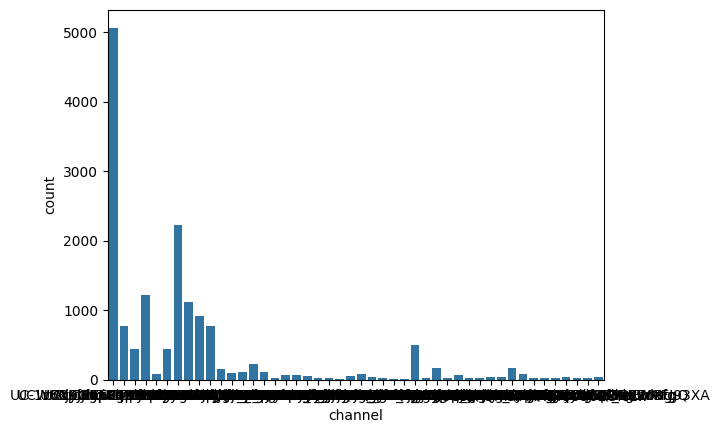

46


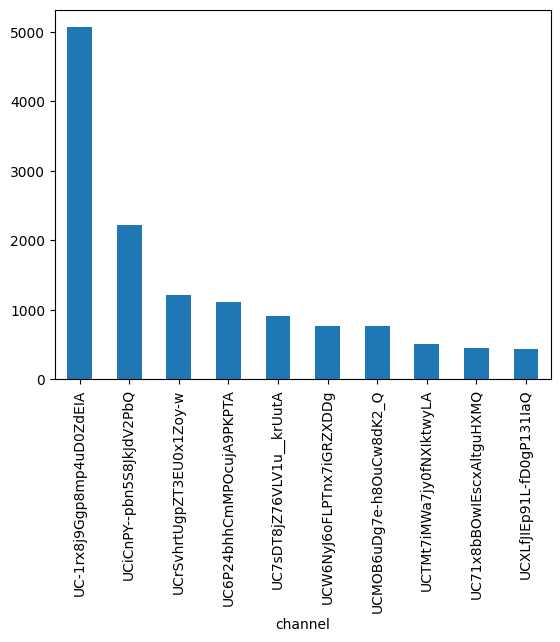

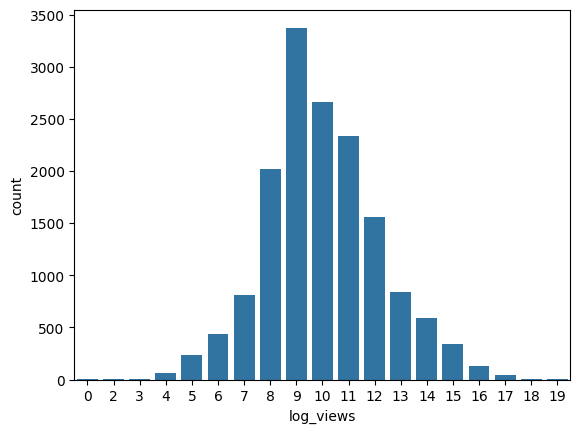

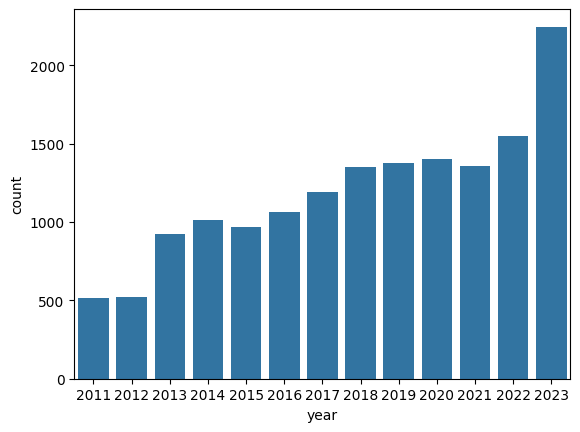

In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

info = pd.read_csv("../dataset/train_val.csv")

# Check required columns
required_columns = ["views", "id", "channel"]
missing = [col for col in required_columns if col not in info.columns]
if missing:
	raise ValueError(f"Missing columns in CSV: {missing}")

# Heavy-tailed?  -> log-transform labels
info["log_views"] = np.int16(np.log1p(info["views"]))
print(np.min(info["log_views"]), np.max(info["log_views"]))
# Category imbalance?

sns.countplot(x="channel", data=info)
plt.show()
top10 = info["channel"].value_counts().head(10)
print(len(info["channel"].unique()))
top10.plot(kind="bar")
plt.show()

sns.countplot(x="log_views", data=info)
plt.show()

sns.countplot(x="year", data=info)
plt.show()



In [1]:
import os
import numpy as np
from PIL import Image
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# 1. List all jpg images in the directory
img_dir = "../dataset/train_val_gpt"
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]

# 2. Load and flatten images (resize for consistency)
features = []
for fname in img_files:
    #img = Image.open(os.path.join(img_dir, fname)).convert('L').resize((64, 64))  # grayscale, 64x64
    img = Image.open(os.path.join(img_dir, fname)).convert('L').resize((64, 64))  # grayscale, 64x64
    features.append(np.array(img).flatten())
features = np.array(features)


On commence le linkage


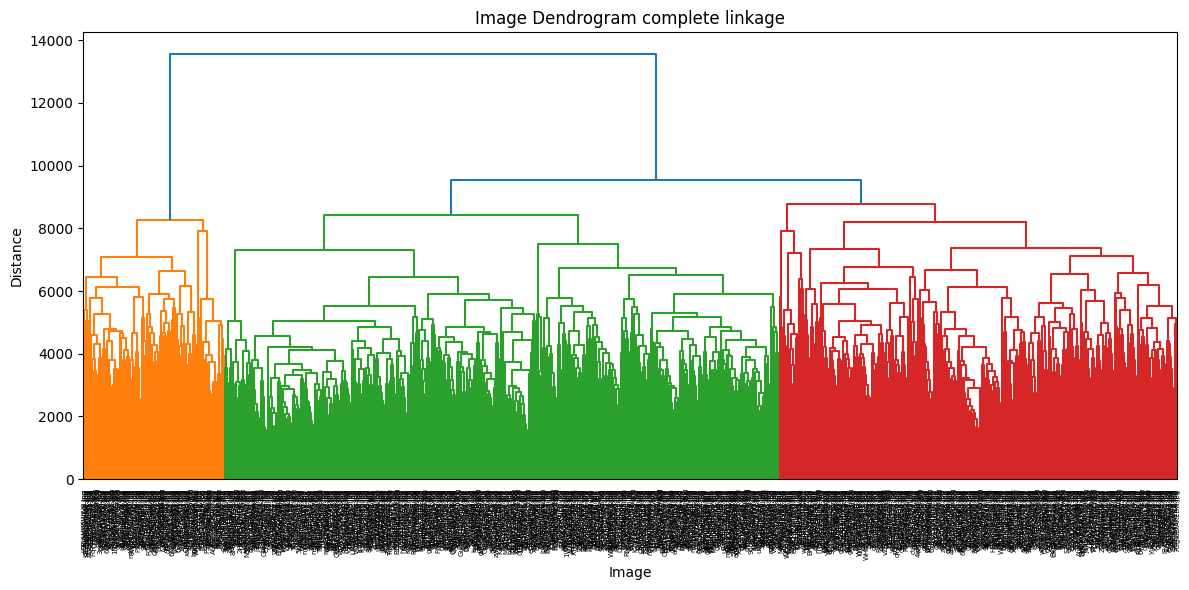

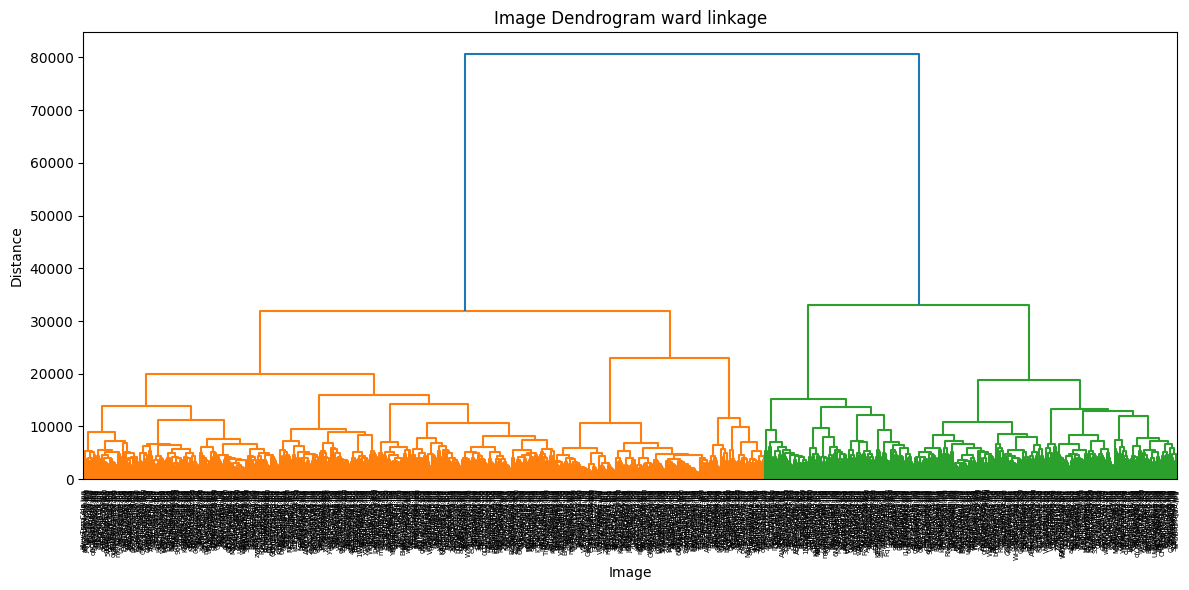

In [23]:

batch_size = 1000  # for example, select 20 random images
num_images = features.shape[0]
random_indices = np.random.choice(num_images, size=batch_size, replace=False)
batch_features = features[random_indices]
batch_img_files = [img_files[i] for i in random_indices]




print("On commence le linkage",flush=True)  # (num_images, 64*64)
# 3. Hierarchical clustering
linked = linkage(batch_features, method='complete', metric='euclidean')

# 4. Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=batch_img_files, leaf_rotation=90)
plt.title('Image Dendrogram complete linkage')
plt.xlabel('Image')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

linked = linkage(batch_features, method='ward', metric='euclidean')

# 4. Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=batch_img_files, leaf_rotation=90)
plt.title('Image Dendrogram ward linkage')
plt.xlabel('Image')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


Les vecteurs sont séparés en deux grandes catégories pour ward (deux boules bien distantes),
Ils sont separé en trois pour complete linkage,

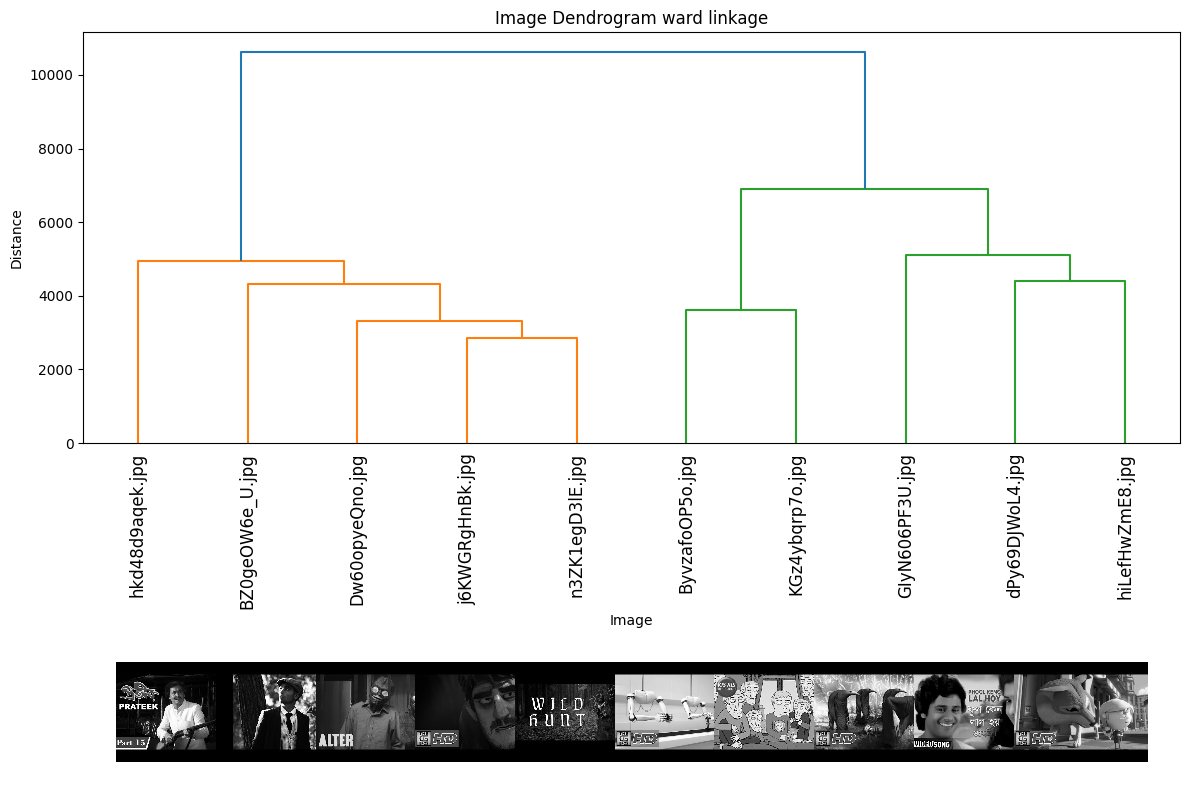

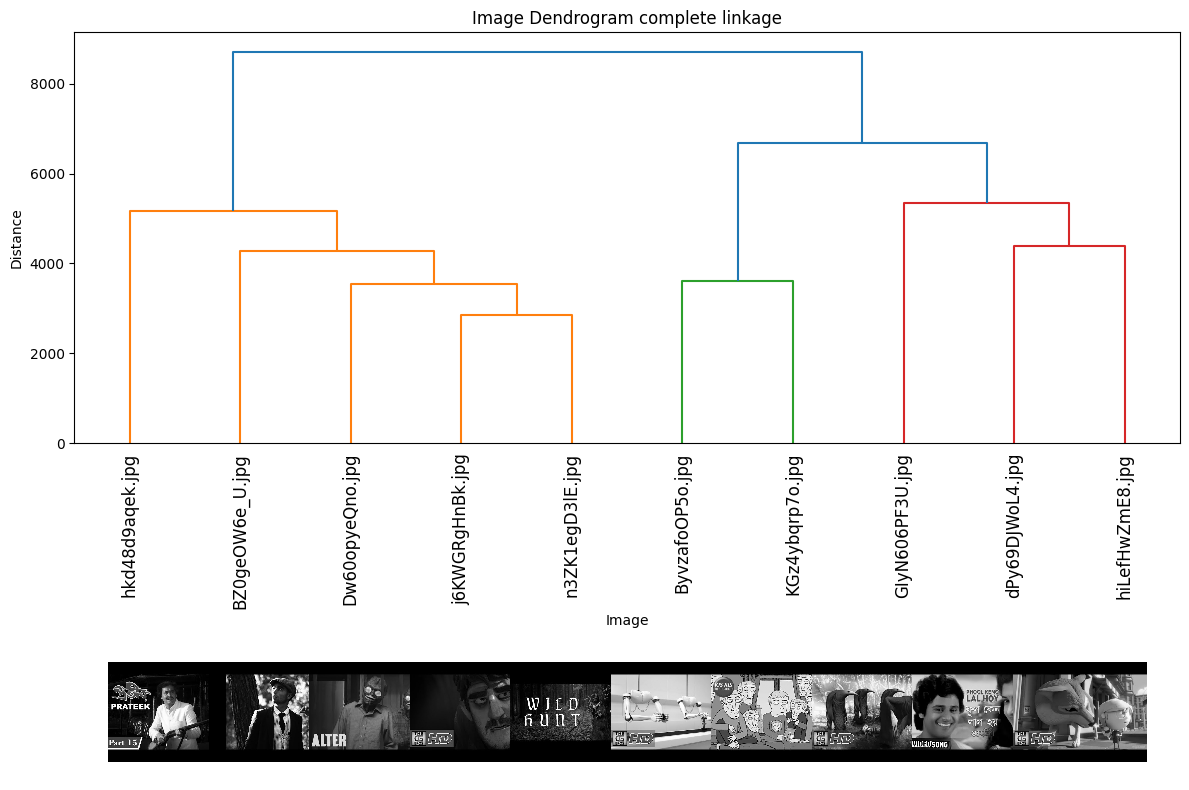

In [26]:
from matplotlib import gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

mini_batch=10
rand_ind2=np.random.choice(batch_size, size=mini_batch, replace=False)
mini_batch_img= [batch_img_files[i] for i in rand_ind2]
mini_features= batch_features[rand_ind2]
# Compute linkage
mini_linked = linkage(mini_features, method='ward')

# Create figure with space for images below
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Dendrogram
ax1 = plt.subplot(gs[0])
ddata = dendrogram(mini_linked, labels=mini_batch_img, leaf_rotation=90, ax=ax1)
ax1.set_title('Image Dendrogram ward linkage')
ax1.set_xlabel('Image')
ax1.set_ylabel('Distance')

# Images below dendrogram
ax2 = plt.subplot(gs[1])
ax2.axis('off')
x_labels = ddata['ivl']  # order of labels as shown by dendrogram

for i, label in enumerate(x_labels):
    img_path = os.path.join(img_dir, label)
    img = Image.open(img_path).convert('L')
    imagebox = OffsetImage(img, zoom=0.2, cmap='gray')  # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (i, 0), frameon=False)
    ax2.add_artist(ab)

ax2.set_xlim(-1, len(x_labels))
ax2.set_ylim(-1, 1)
plt.tight_layout()
plt.show()



mini_linked = linkage(mini_features, method='complete')

# Create figure with space for images below
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# Dendrogram
ax1 = plt.subplot(gs[0])
ddata = dendrogram(mini_linked, labels=mini_batch_img, leaf_rotation=90, ax=ax1)
ax1.set_title('Image Dendrogram complete linkage')
ax1.set_xlabel('Image')
ax1.set_ylabel('Distance')

# Images below dendrogram
ax2 = plt.subplot(gs[1])
ax2.axis('off')
x_labels = ddata['ivl']  # order of labels as shown by dendrogram

for i, label in enumerate(x_labels):
    img_path = os.path.join(img_dir, label)
    img = Image.open(img_path).convert('L')
    imagebox = OffsetImage(img, zoom=0.2, cmap='gray')  # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (i, 0), frameon=False)
    ax2.add_artist(ab)

ax2.set_xlim(-1, len(x_labels))
ax2.set_ylim(-1, 1)
plt.tight_layout()
plt.show()


C'est peut-être gens/pas gens: les clusters sont un eu les mêmes entre complete et ward

In [27]:
from scipy.cluster.hierarchy import fcluster

# linked: the linkage matrix from linkage()
# t: the distance threshold you want (e.g., t=50)
# criterion='distance' means clusters are formed when the linkage distance is <= t
clusters = fcluster(linked, t=60000, criterion='distance')

# clusters is an array of cluster labels (same order as your input data)
